## Model Analysis Notebook

In this notebook, we train, test, and evaluate the performance of an LSTM model in wind speed prediction and compare results to the persistence method, which is a common benchmark for wind speed prediction algorithms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import tensorflow as tf
import keras
from keras.layers import Input, LSTM, Dense, Dropout, Flatten

In [2]:
# Define how many time steps will be used in observation and prediction
n_past = 24 # The last day of data
n_future = 24 # The next day of data
n_features = 3

In [3]:
# Define a function to split the series using a sliding window
def split_series(series, n_past=n_past, n_future=n_future, offset=0):
    X, y = list(), list()
    for i in range(int(len(series)/n_past)-1):
        X.append(series[i*n_past : i*n_past + n_past, :])
        y.append(series[offset + i*n_past + n_past : offset + i*n_past + n_past + n_future, :])
    return np.array(X), np.array(y)

In [4]:
# Process and split the data for a site given its filename
def prep_data(filename, cy=2015):
    # Import the data for a single point
    data = pd.read_csv("Data/NOW-23 Great Lakes [2000-2020] 60min/" + filename, index_col=0)

    # Restrict the data to the last 5 years, giving us 4 years of training and 1 year of testing data
    data = data.iloc[int(len(data)*(cy-2000)/20):]

    # Split the data into training and testing samples
    cutoff = int(len(data)*0.8)
    test_data = data[cutoff:]
    data = data[:cutoff]
    
    # Designate which columns are used for training
    columns = [6, 7, 8]
    
    # Normalize the testing and training data
    test_data.iloc[:, columns], test_norms = normalize(test_data.iloc[:, columns], axis=0, norm='max', return_norm=True)
    data.iloc[:, columns], train_norms = normalize(data.iloc[:, columns], axis=0, norm='max', return_norm=True)

    # Split the data into series for training
    X_train, y_train = split_series(np.array(data.iloc[:, columns]), n_future=1, offset=24-1)
    X_test, y_test = split_series(np.array(test_data.iloc[:, columns]), n_future=1, offset=24-1)

    # Adjust the expected output to contain only the wind speed
    y_train, y_test = y_train[:, :, 2], y_test[:, :, 2]
    
    return X_train, y_train, X_test, y_test, train_norms, test_norms

In [5]:
# Define the model architecture
def define_model():
    # Original model used for testing
    '''
    model = keras.models.Sequential()
    model.add(Input(shape=(n_past, n_features)))
    model.add(LSTM(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='mae')
    '''


    # Lighter model used for additional training
    model = keras.models.Sequential()
    model.add(Input(shape=(n_past, n_features)))
    model.add(LSTM(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='mae')

    return model

In [6]:
model = define_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train one model with data starting at different years
df = pd.DataFrame()
df['Years'] = list()
df['MAE'] = list()
for year in range(2000, 2020):
    print(f"{year}")

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data('7871.csv', cy=year)
    model = define_model()
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=128)

    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * test_norms[2])

    df.loc[len(df) + 1] = [int(year), mae]

2000
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2203 - val_loss: 0.1298
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1317 - val_loss: 0.1187
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1134 - val_loss: 0.1166
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1122 - val_loss: 0.1150
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1096 - val_loss: 0.1128
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1077 - val_loss: 0.1115
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1051 - val_loss: 0.1100
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1041 - val_loss: 0.1098
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1036 - val_loss: 0.1086
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1046 - val_loss: 0.1082
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1018 - val_loss: 0.1071
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

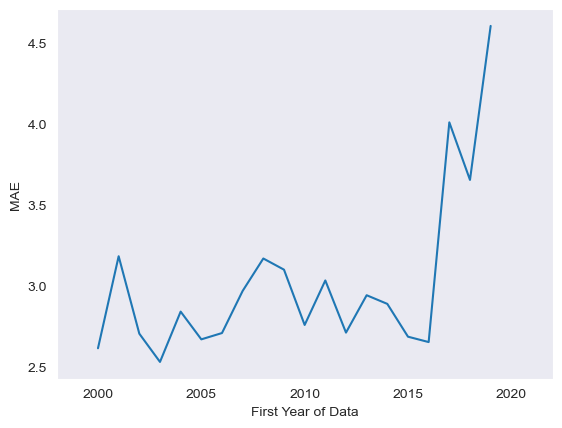

In [28]:
# Display the data for use as a figure
plt.xlabel('First Year of Data')
plt.ylabel('MAE')
plt.grid(False)
plt.xlim(1998, 2022)
plt.plot(df['Years'], df['MAE'])

In [18]:
# Train one model with a varying number of epochs
df = pd.DataFrame()
df['Epochs'] = list()
df['MAE'] = list()
for epoch in range(10, 160, 10):
    print(f"{epoch}")

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data('7871.csv')
    model = define_model()
    model.fit(X_train,y_train,epochs=epoch,validation_data=(X_test,y_test),batch_size=128)
        
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * test_norms[2])
        
    df.loc[len(df)+1] = [int(epoch), mae]

10
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1995 - val_loss: 0.1374
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1609 - val_loss: 0.1259
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1551 - val_loss: 0.1280
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1512 - val_loss: 0.1263
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1440 - val_loss: 0.1215
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1429 - val_loss: 0.1228
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1383 - val_loss: 0.1213
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1358 - val_loss: 0.1197
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1322 - val_loss: 0.1197
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1350 - val_loss: 0.1193
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
20
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2950 - val_loss: 0.2607
Epoch 2/20
12/12 ━━━━━━━━━━

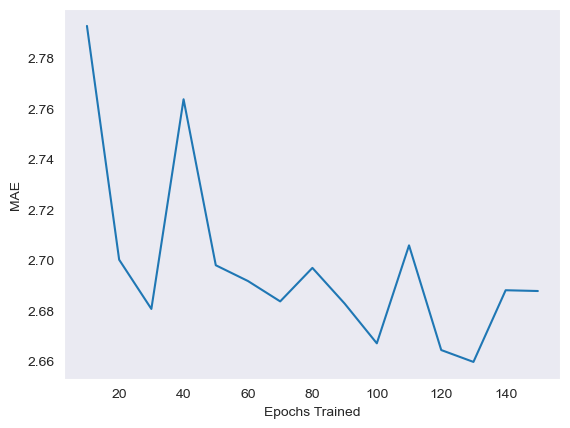

In [20]:
# Display the data for use as a figure
plt.xlabel('Epochs Trained')
plt.ylabel('MAE')
plt.grid(False)
plt.plot(df['Epochs'], df['MAE'])

In [7]:
# Train models for every selected site
i = 1
for filename in os.listdir("Data/NOW-23 Great Lakes [2000-2020] 60min"):
    print(f"Point number {i} of 100")
    i += 1

    model = define_model()
    
    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename, cy=2015)
    
    model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=128)
    model.save("Data/Models/" + filename[:-4] + ".keras")

Point number 1 of 100
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2583 - val_loss: 0.2492
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2080 - val_loss: 0.1678
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1590 - val_loss: 0.1494
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1448 - val_loss: 0.1504
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1343 - val_loss: 0.1489
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1270 - val_loss: 0.1469
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1286 - val_loss: 0.1456
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1256 - val_loss: 0.1460
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1248 - val_loss: 0.1460
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1235 - val_loss: 0.1437
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1218 - val_loss: 0.1423
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

In [31]:
# Test models for every selected site
mae, sites = list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv', cy=2015)
    model = keras.saving.load_model("Data/Models/" + filename)
    model.compile(optimizer='adam', loss='mae')
    
    predictions = model.predict(X_test)
    mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * test_norms[2]))
    sites.append(filename[:-6])
    print(mae[-1])
df = pd.DataFrame()
df['MAE'] = pd.Series(mae)
df['SiteID'] = pd.Series(sites)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3.441897584106286
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.1404579268700163
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.9400131646001526
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2.6899856960336574
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.7648300017112217
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.9989391904601255
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.3472245507464984
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2.811686909311105
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.4195619160717077
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.2612312503634944
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.4485266951615903
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.739156031284032
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.772828566016951
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.9219839969854706
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
3.562117406435662
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.568724542837492
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.9328048544279564
12/

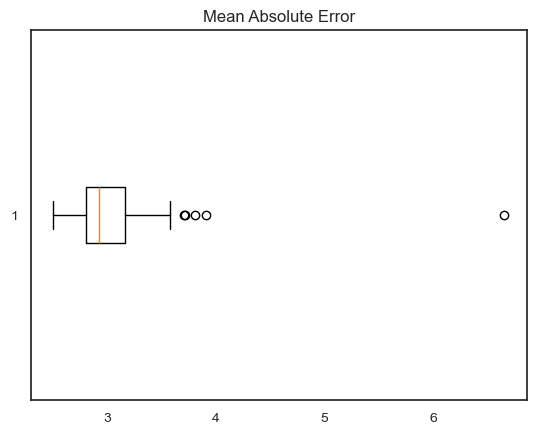

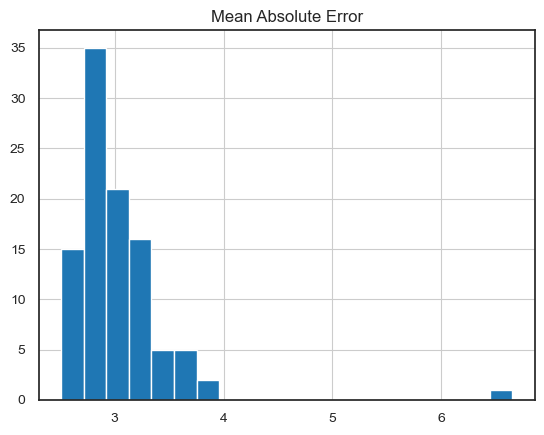

C:\Users\shell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


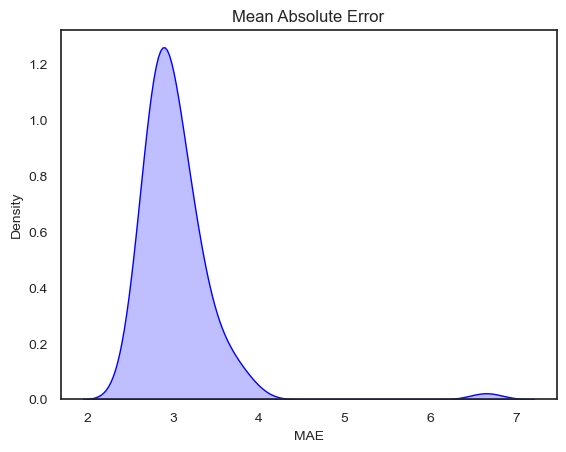

In [32]:
# Generate a box plot to describe the MAE distribution for use as a figure
plt.style.use('seaborn-v0_8-ticks')
plt.boxplot(df['MAE'], vert=False)
plt.title("Mean Absolute Error")
plt.show()

# We use the box plot as a figure, but a histogram and KDE can also represent the MAE distribution
df['MAE'].hist(bins=20)
plt.title("Mean Absolute Error")
plt.show()

sns.kdeplot(df['MAE'], color="blue", fill=True)
plt.title("Mean Absolute Error")
plt.show()

In [33]:
# We can print out some statistics of the distribution in detail
print(f"Mean: {np.average(df['MAE'])}")
print(f"Median: {np.median(df['MAE'])}")
print(f"Standard Deviation: {np.std(df['MAE'])}")
print(f"n: {len(df['MAE'])}")

Mean: 3.0328596858820998
Median: 2.9273944257067135
Standard Deviation: 0.4632867320234037
n: 100


In [9]:
# Finally, we repeat this analysis with a persistence model that uses the wind speed from 24h before as a prediction, demonstrating the superiority of the LSTM model

mae, rmse, sites = list(), list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv', cy=2000)

    predictions = [x[-1] for x in X_test[:, :, -1]]
    mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2]))
    rmse.append(np.sqrt(mean_squared_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2])))
    sites.append(filename[:-6])

df1 = pd.DataFrame()
df1['MAE'] = pd.Series(mae)
df1['RMSE'] = pd.Series(rmse)
df1['SiteID'] = pd.Series(sites)

In [10]:
# We compare the persistence model on a variety of loss metrics
print(f"Average MAE of the persistence model: {np.average(df1['MAE'])}")
print(f"Median MAE of the persistence model: {np.median(df1['MAE'])}")
print(f"Average RMSE of the persistence model: {np.average(df1['RMSE'])}")
print(f"Median RMSE of the persistence model: {np.median(df1['RMSE'])}")

print("\n")
print(f"The persistence model has a higher MAE by {(np.average(df1['MAE'])/np.average(df['MAE']) - 1) * 100}%")
print(f"Median difference: {(np.median(df1['MAE'])/np.median(df['MAE']) - 1) * 100}%")
# Unsurpisingly, the both the median and average MAE of the persistence model are around 25-30% higher than the average LSTM model MAE over all sites

Average MAE of the persistence model: 3.8854124673629244
Median MAE of the persistence model: 3.789934725848564
Average RMSE of the persistence model: 4.956492185369164
Median RMSE of the persistence model: 4.827821027636594


NameError: name 'df' is not defined

In [7]:
# To describe the differences in train time with different model parameters, we train 3 models, each encompassing the 100 selected points in the study.
df = pd.DataFrame()
df['Average MAE'] = list()
df['Median MAE'] = list()
df['Average RMSE'] = list()
df['Median RMSE'] = list()
df['Train_time'] = list()
df['Train_time std'] = list()

for pair in [[100, 2000], [100, 2015], [50, 2015]]:
    # Train models for every selected site

    mae, rmse, time_elapsed = list(), list(), list()
    i = 1
    for filename in os.listdir("Data/NOW-23 Great Lakes [2000-2020] 60min"):
        print(f"Point number {i} of 100")
        i += 1
        
        start_time = datetime.now()
        model = define_model()
        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename, cy=pair[1])
        model.fit(X_train,y_train,epochs=pair[0],validation_data=(X_test,y_test),batch_size=128)

        predictions = model.predict(X_test)
        mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2]))
        rmse.append(np.sqrt(mean_squared_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2])))
    
        time_elapsed.append((datetime.now() - start_time).total_seconds())
    df.loc[len(df)+1] = [np.average(mae), np.median(mae), np.average(rmse), np.median(rmse), np.average(time_elapsed), np.std(time_elapsed)]
df['Model'] = ['100 epochs, 20 years', '100 epochs, 5 years', '50 epochs, 5 years']

Point number 1 of 100
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2034 - val_loss: 0.1371
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1262 - val_loss: 0.1297
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1134 - val_loss: 0.1265
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1084 - val_loss: 0.1250
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1093 - val_loss: 0.1255
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1062 - val_loss: 0.1239
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1043 - val_loss: 0.1243
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1046 - val_loss: 0.1216
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1018 - val_loss: 0.1212
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1031 - val_loss: 0.1204
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0999 - val_loss: 0.1189
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 

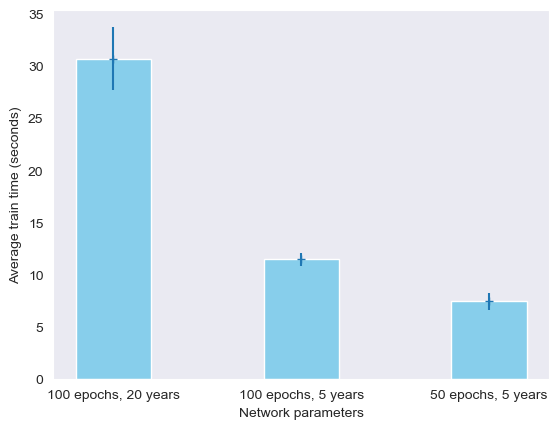

In [14]:
# Now we can generate a figure to demonstrate the significant change in train time between the models
plt.bar(df['Model'], df['Train_time'], width=0.4, color="skyblue")
plt.errorbar(df['Model'], df['Train_time'], yerr=df['Train_time std'], fmt="+")
plt.grid(False)
plt.ylabel("Average train time (seconds)")
plt.xlabel("Network parameters")
plt.show()

In [15]:
# We also compare the models to persistence, finding no major differences between the models in performance but significant improvements over persistence
df.loc[len(df)+1] = [np.average(df1['MAE']), np.median(df1['MAE']), np.average(df1['RMSE']), np.median(df1['RMSE']), 0, "Persistence"]
df.drop('Train_time', inplace=True, axis=1)
display(df)

Average MAE  Median MAE  Average RMSE  Median RMSE                 Model
1     3.012834    2.935909      3.856681     3.752786  100 epochs, 20 years
2     2.991567    2.932584      3.914369     3.834629   100 epochs, 5 years
3     3.002933    2.923593      3.934388     3.878552    50 epochs, 5 years
4     3.844784    3.782251      4.935832     4.849352           Persistence